# URL Phishing Detection

In this notebook, we aim to build a machine learning model that can accurately classify URLs as either **malicious (phishing)** or **benign (legitimate)** based on their structural characteristics. Unlike natural language processing approaches used for email body content, URLs require a feature-engineering-based strategy, focusing on patterns like length, presence of suspicious keywords, number of dots or slashes, and more.

We'll use the **Malicious URLs Dataset** from Kaggle, extract relevant features from each URL, train a classification model, evaluate its performance, and save the best-performing model for production use in our unified phishing detection system.

📌 **Goal**: Achieve at least **95% accuracy** in detecting phishing URLs, while maintaining low false positives to ensure reliability in real-world scenarios.

**Imports**:

In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
import re
from urllib.parse import urlparse, parse_qs

# Model Training
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Hyperparameter Tuning
import optuna

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Model Saving
import joblib

# Plot Style
sns.set_style('dark')

**Load the Dataset**:

In [2]:
# Load the Dataset
df = pd.read_csv('../data/malicious_phish.csv')
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


## Exploratory Data Analysis (EDA)

In this section, we will perform Exploratory Data Analysis (EDA) to better understand the structure and distribution of the dataset. We'll examine the balance between phishing and benign URLs, check for missing values, and identify any patterns or inconsistencies that could influence feature extraction. This step ensures we have a clear understanding of the data before moving into feature engineering and model training.

**Basics**:

In [3]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [5]:
df.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [6]:
df.isna().sum()

url     0
type    0
dtype: int64

In [7]:
df['url'].duplicated().sum()

np.int64(10072)

The dataset contains **651,191 URL entries** across two columns: `url` and `type`. There are **no missing values**, but we found **10,072 duplicate URLs**, which we may choose to remove to avoid bias. The `type` column has four unique values, with `'benign'` being the most frequent, appearing over 428,000 times. Before moving on, we’ll explore the label distribution and decide whether to filter or merge any classes for binary classification (e.g., phishing vs. non-phishing).

In [8]:
df['type'].unique()

array(['phishing', 'benign', 'defacement', 'malware'], dtype=object)

The `type` column contains four categories: `'phishing'`, `'malware'`, `'defacement'`, and `'benign'`. Since our goal is to classify URLs as either **malicious** or **legitimate**, we will convert this into a binary classification task. Specifically, `'phishing'`, `'malware'`, and `'defacement'` will be grouped under the **malicious** class (label `1`), while `'benign'` will remain as **legitimate** (label `0`). This approach simplifies the task and aligns with our existing email phishing detection model.

In [9]:
df['url_length'] = df['url'].apply(len)

**Drop the Duplicates**:

In [10]:
df = df.drop_duplicates(subset='url')
df['url'].duplicated().sum()

np.int64(0)

**Encode the Type**:

In [11]:
df.loc[:, 'label'] = df['type'].apply(lambda x: 0 if x=='benign' else 1)
df['label'].unique()

array([1, 0])

In [12]:
df = df.drop(columns=['type'])

In [13]:
df['label'].value_counts(normalize=True) * 100

label
0    66.770756
1    33.229244
Name: proportion, dtype: float64

In [14]:
df.head()

,url,url_length,label
0,br-icloud.com.br,16,1
1,mp3raid.com/music/krizz_kaliko.html,35,0
2,bopsecrets.org/rexroth/cr/1.htm,31,0
3,http://www.garage-pirenne.be/index.php?option=...,88,1
4,http://adventure-nicaragua.net/index.php?optio...,235,1


We have succesfully dropped the duplicates and encode the label!

**Visualization**:

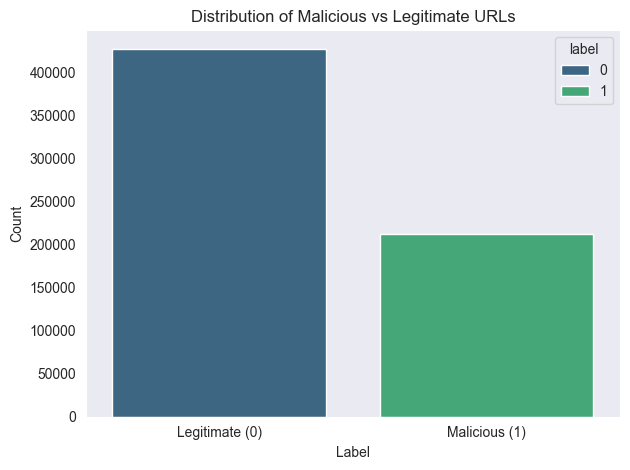

In [15]:
label_counts = df['label'].value_counts()

# Create Bar Plot
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette='viridis')
plt.title('Distribution of Malicious vs Legitimate URLs')
plt.ylabel('Count')
plt.xlabel('Label')
plt.xticks([0, 1], ['Legitimate (0)', 'Malicious (1)'])
plt.tight_layout()

# Save the plot
plt.savefig(fname='../images/Distribution_Malicious_vs_Legitimate_URLs.png')

# Show the plot
plt.show()

The dataset is not fully balanced, but we do have enough malicious URLs

In [16]:
df.head()

,url,url_length,label
0,br-icloud.com.br,16,1
1,mp3raid.com/music/krizz_kaliko.html,35,0
2,bopsecrets.org/rexroth/cr/1.htm,31,0
3,http://www.garage-pirenne.be/index.php?option=...,88,1
4,http://adventure-nicaragua.net/index.php?optio...,235,1


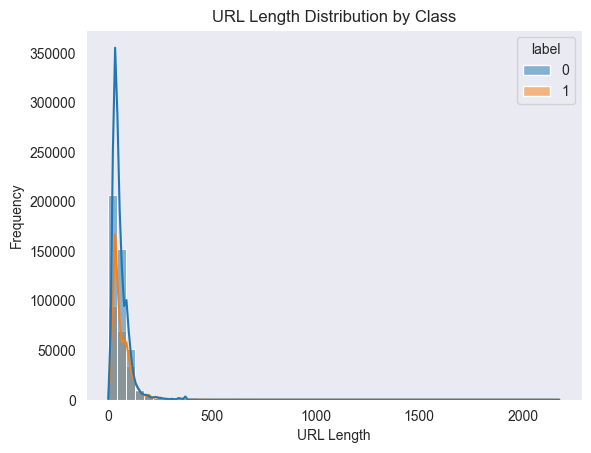

In [17]:
# Create Histogram Plot
sns.histplot(data=df, x='url_length', hue='label', kde=True, bins=50)
plt.title('URL Length Distribution by Class')
plt.xlabel('URL Length')
plt.ylabel('Frequency')

# Save as Image
plt.savefig(fname='../images/URL_Length_Distribution_By_Class.png')

# Show the Plot
plt.show()

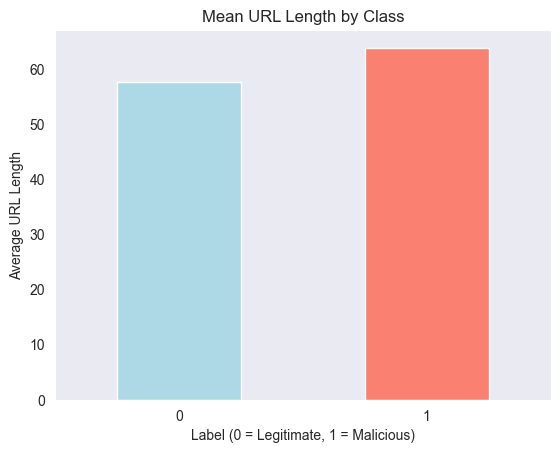

In [18]:
# Get the mean of the URL length based on the label
mean_length = df.groupby('label')['url_length'].mean()

# Plot
mean_length.plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Mean URL Length by Class')
plt.xlabel('Label (0 = Legitimate, 1 = Malicious)')
plt.ylabel('Average URL Length')
plt.xticks(rotation=0)

# Save as Image
plt.savefig(fname='../images/Mean_URL_Length_By_Class.png')

# Show the Plot
plt.show()

## Feature Engineering

In this section, we'll transform each URL into a set of meaningful numerical features that can help a machine learning model distinguish between malicious and legitimate URLs. Since URLs are structured strings, we'll extract features such as the total length of the URL, number of dots and hyphens, presence of an IP address, use of HTTPS, and inclusion of suspicious keywords like "login" or "verify". These handcrafted features will serve as the input for our machine learning models.

In [19]:
def extract_features(url: str) -> dict:
    parsed_url = urlparse(url)
    hostname = parsed_url.hostname or ""
    path = parsed_url.path
    query = parsed_url.query

    subdomain_parts = hostname.split('.')[:-2]
    domain_keywords = ['paypal', 'google', 'apple', 'amazon', 'microsoft', 'facebook']
    sensitive_keywords = ['secure', 'login', 'account', 'update', 'verify', 'password', 'bank', 'confirm']

    return {
        'url_length': len(url),
        'num_of_dots': url.count('.'),
        'sub_domain_lvl': max(len(hostname.split('.')) - 2, 0),
        'path_level': path.count('/'),
        'num_of_dash': url.count('-'),
        'num_of_dash_hostname': hostname.count('-'),
        'has_at_symbol': int('@' in url),
        'has_tilde_symbol': int('~' in url),
        'num_of_underscore': url.count('_'),
        'num_of_percent': url.count('%'),
        'num_query_components': len(parse_qs(query)),
        'num_of_ampersand': url.count('&'),
        'num_of_hash': url.count('#'),
        'num_numeric_chars': sum(c.isdigit() for c in url),
        'no_https': int(not url.lower().startswith('https')),
        'random_string': int(bool(re.match(r'^[a-zA-Z0-9]{10,}$', path.split('/')[-1]))),
        'has_ip_address': int(bool(re.search(r'(\d{1,3}\.){3}\d{1,3}', url))),
        'domain_in_subdomains': int(any(kw in '.'.join(subdomain_parts).lower() for kw in domain_keywords)),
        'domain_in_paths': int(any(kw in path.lower() for kw in domain_keywords)),
        'https_in_hostname': int('https' in hostname.lower()),
        'hostname_length': len(hostname),
        'path_length': len(path),
        'query_length': len(query),
        'num_sensitive_words': sum(word in url.lower() for word in sensitive_keywords),
        'embedded_brand': int(any(kw in url.lower() for kw in domain_keywords))
    }

In [20]:
features_df = df['url'].apply(extract_features).apply(pd.Series)

In [21]:
features_df['label'] = df['label'].values

In [22]:
features_df.head()

,url_length,num_of_dots,sub_domain_lvl,path_level,num_of_dash,num_of_dash_hostname,has_at_symbol,has_tilde_symbol,num_of_underscore,num_of_percent,...,has_ip_address,domain_in_subdomains,domain_in_paths,https_in_hostname,hostname_length,path_length,query_length,num_sensitive_words,embedded_brand,label
0,16,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,16,0,0,0,1
1,35,2,0,2,0,0,0,0,1,0,...,0,0,0,0,0,35,0,0,0,0
2,31,2,0,3,0,0,0,0,0,0,...,0,0,0,0,0,31,0,0,0,0
3,88,3,1,1,1,1,0,0,2,0,...,0,0,0,0,21,10,49,0,0,1
4,235,2,0,1,1,1,0,0,1,0,...,0,0,0,0,23,10,194,0,0,1


In [23]:
# Save the new dataset
features_df.to_csv('../data/url_features_extracted.csv', index=False)

## Model Training

In this section, we will train several machine learning models on the extracted URL features to classify whether a URL is malicious or legitimate. We'll begin by splitting the dataset into training and test sets, then train models such as **Logistic Regression**, **Random Forest**, and **XGBoost**. Our goal is to identify the model that provides the best accuracy and generalization performance on unseen data, ideally achieving **95%+ accuracy** while minimizing false positives.

**Prepare the Data**

In [24]:
# Get X and y
X = features_df.drop('label', axis=1)
y = features_df['label']

# Split to Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Logistic Regression**

In [25]:
# Initiate and Fit the Model
lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(X_train, y_train)

# Print the Score
lr_score = lr_model.score(X_test, y_test)
print(f"Logistic Regression Base Model's Score: {lr_score}")

# Get the Predicts
y_pred_lr = lr_model.predict(X_test)

Logistic Regression Base Model's Score: 0.8718960569004243


Accuracy: 0.8718960569004243

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91     85616
           1       0.94      0.66      0.77     42608

    accuracy                           0.87    128224
   macro avg       0.89      0.82      0.84    128224
weighted avg       0.88      0.87      0.87    128224



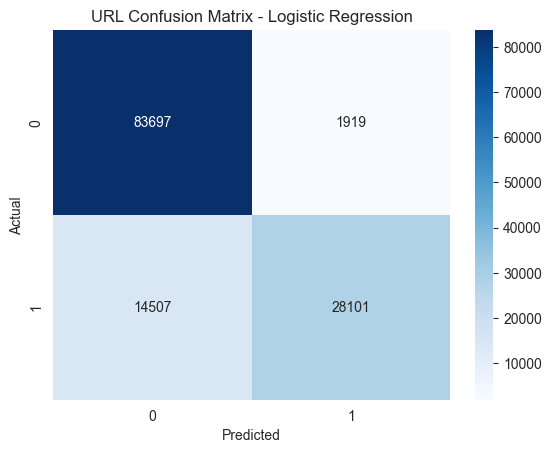

In [26]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# Detailed Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('URL Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Save as Image
plt.savefig(fname='../images/URL_Logistic_Regression_Confusion_Matrix.png')

# Show the Plot
plt.show()

Logistic Regression provided a strong baseline with an accuracy of **87.19%**. The model demonstrated high precision for detecting malicious URLs (**94%**), but recall was lower (**66%**), indicating it missed a significant number of phishing cases. This is expected for linear models with imbalanced feature importance. While it performs well on legitimate URLs, we need a more powerful classifier to improve detection of malicious ones. We'll now train a **Random Forest** model to see if we can boost recall and overall performance.

**Random Forest Classifier**

In [27]:
# Initiate and Fit the Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Print the Score
rf_score = rf_model.score(X_test, y_test)
print(f"Random Forest Classifier Base Model's Score: {rf_score}")

# Get the Predicts
y_pred_rf = rf_model.predict(X_test)

Random Forest Classifier Base Model's Score: 0.9497753930621412


Accuracy: 0.9497753930621412

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96     85616
           1       0.94      0.91      0.92     42608

    accuracy                           0.95    128224
   macro avg       0.95      0.94      0.94    128224
weighted avg       0.95      0.95      0.95    128224



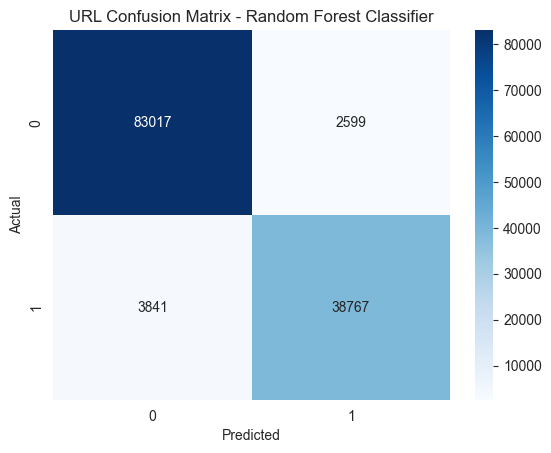

In [28]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# Detailed Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('URL Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Save as Image
plt.savefig(fname='../images/URL_Random_Forest_Confusion_Matrix.png')

# Show the Plot
plt.show()

The Random Forest model significantly outperformed Logistic Regression, achieving **94.98% accuracy**. It maintained a strong balance between precision (**94%**) and recall (**91%**) on malicious URLs, which makes it far more reliable for phishing detection. The confusion matrix shows a notable drop in false negatives, meaning far fewer malicious URLs were missed. This model is highly promising and may already be production-ready, but we’ll continue with **XGBoost** to see if we can push performance even further.

**XGBoost**

In [29]:
# Initiate and Fit the Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Print the Score
xgb_score = xgb_model.score(X_test, y_test)
print(f"XGBoost Base Model's Score: {xgb_score}")

# Get the Predicts
y_pred_xgb = xgb_model.predict(X_test)

C:\Users\emrev\PycharmProjects\EmailPhishingDetection\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:34:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Base Model's Score: 0.9466636511105565


Accuracy: 0.9466636511105565

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     85616
           1       0.94      0.90      0.92     42608

    accuracy                           0.95    128224
   macro avg       0.95      0.93      0.94    128224
weighted avg       0.95      0.95      0.95    128224



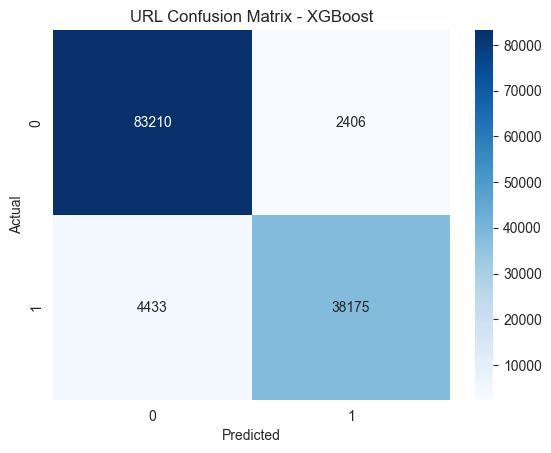

In [30]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Detailed Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title('URL Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Save as Image
plt.savefig(fname='../images/URL_XGBoost_Confusion_Matrix.png')

# Show the Plot
plt.show()

XGBoost achieved a high accuracy of **94.67%**, very close to the performance of Random Forest. It maintained strong precision (**94%**) and recall (**90%**) on phishing URLs, making it a reliable and efficient option. While Random Forest slightly outperformed XGBoost in recall, both models demonstrated production-level performance. Depending on future tuning and inference speed needs, either can be selected as the final model for deployment.

## Hyperparameter Tuning with Optuna

To further improve model performance, we perform hyperparameter tuning using **Optuna**, a powerful optimization framework. Instead of manually selecting parameters, Optuna uses intelligent search techniques to automatically find the best combination of hyperparameters that maximize our chosen evaluation metric. In this case, we aim to **maximize the F1-score**, which balances precision and recall — especially important in phishing detection where both false positives and false negatives have serious consequences. We'll tune both the **Random Forest** and **XGBoost** classifiers using cross-validation.

**Random Forest Classifier**

In [31]:
# Define Objective Function for Random Forest
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }
    model = RandomForestClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='f1').mean()
    return score

In [32]:
# Run Optuna Study
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)

# Best Parameters
print("Best Hyperparameters for Random Forest:")
print(study_rf.best_params)

[I 2025-05-30 18:39:47,615] A new study created in memory with name: no-name-c377494e-8586-432b-858a-81ca71139d54
[I 2025-05-30 18:41:07,810] Trial 0 finished with value: 0.8684248062535488 and parameters: {'n_estimators': 269, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.8684248062535488.
[I 2025-05-30 18:41:30,923] Trial 1 finished with value: 0.8510986456764823 and parameters: {'n_estimators': 102, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.8684248062535488.
[I 2025-05-30 18:42:36,124] Trial 2 finished with value: 0.9184206837607832 and parameters: {'n_estimators': 125, 'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9184206837607832.
[I 2025-05-30 18:44:20,889] Trial 3 finished with value: 0.9107766059077965 and parameters: {'n_estimators': 253, 'max_depth': 18, 'mi

Best Hyperparameters for Random Forest:
{'n_estimators': 269, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [33]:
# Train the Final Tuned Model
rf_model = RandomForestClassifier(**study_rf.best_params, random_state=42)
rf_model.fit(X_train, y_train)

# Print the Score
rf_score = rf_model.score(X_test, y_test)
print(f"Random Forest Classifier Tuned Model's Score: {rf_score}")

# Get the Predictions
y_pred_rf = rf_model.predict(X_test)

Random Forest Classifier Tuned Model's Score: 0.9509764162715248


Accuracy: 0.9509764162715248

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     85616
           1       0.94      0.91      0.92     42608

    accuracy                           0.95    128224
   macro avg       0.95      0.94      0.94    128224
weighted avg       0.95      0.95      0.95    128224



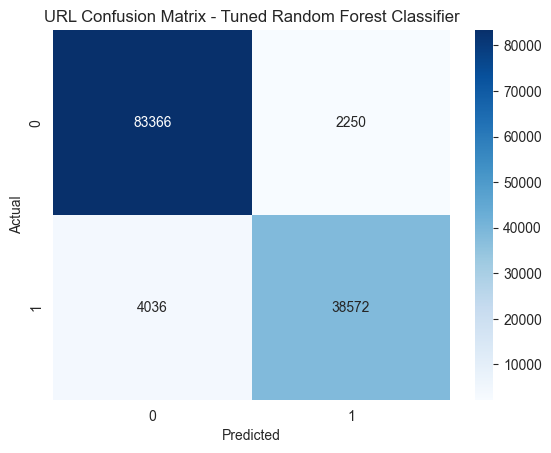

In [34]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# Detailed Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('URL Confusion Matrix - Tuned Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Save the Plot
plt.savefig(fname='../images/URL_Tuned_Random_Forest_Confusion_Matrix.png')
plt.show()

After hyperparameter tuning with Optuna, the Random Forest model reached an accuracy of **95.10%**, with strong precision (**94%**) and recall (**91%**) on malicious URLs. While the overall accuracy slightly improved over the base model, the real benefit came from reducing false positives and slightly improving consistency. The model now shows excellent balance, making it a highly reliable candidate for deployment.

**XGBoost**

In [38]:
# Define Objective Function for XGBoost
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),
        'tree_method': 'hist',
        'device': 'cuda',
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='f1').mean()
    return score

In [39]:
# Run Optuna Study
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

# Print Best Params
print("Best Hyperparameters for XGBoost:")
print(study_xgb.best_params)

[I 2025-05-30 20:05:23,535] A new study created in memory with name: no-name-03d98d5a-4d70-4633-a70c-0e1d64b40c7b
[I 2025-05-30 20:05:25,953] Trial 0 finished with value: 0.9155575898828691 and parameters: {'n_estimators': 212, 'max_depth': 10, 'learning_rate': 0.2593101318743404, 'subsample': 0.6991509704348586, 'colsample_bytree': 0.748192050730482, 'gamma': 4.9274478991991115, 'reg_lambda': 9.98192867910562}. Best is trial 0 with value: 0.9155575898828691.
[I 2025-05-30 20:05:28,386] Trial 1 finished with value: 0.9148866062857768 and parameters: {'n_estimators': 291, 'max_depth': 6, 'learning_rate': 0.2595975326085403, 'subsample': 0.6578176654443817, 'colsample_bytree': 0.888150593696269, 'gamma': 4.671355758516875, 'reg_lambda': 0.9602346060849979}. Best is trial 0 with value: 0.9155575898828691.
[I 2025-05-30 20:05:31,065] Trial 2 finished with value: 0.9175526814252377 and parameters: {'n_estimators': 220, 'max_depth': 12, 'learning_rate': 0.1692128183961673, 'subsample': 0.751

Best Hyperparameters for XGBoost:
{'n_estimators': 292, 'max_depth': 20, 'learning_rate': 0.12402973383598716, 'subsample': 0.9836001134077504, 'colsample_bytree': 0.998926473970416, 'gamma': 0.19423676357331132, 'reg_lambda': 3.279788157686834}


In [40]:
# Train the Final Tuned Model
xgb_model = XGBClassifier(**study_xgb.best_params, random_state=42)
xgb_model.fit(X_train, y_train)

# Print the Score
xgb_score = xgb_model.score(X_test, y_test)
print(f"XGBoost Classifier Tuned Model's Score: {xgb_score}")

# Get the Predictions
y_pred_xgb = xgb_model.predict(X_test)

XGBoost Classifier Tuned Model's Score: 0.9513585600199651


Accuracy: 0.9513585600199651

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96     85616
           1       0.94      0.91      0.93     42608

    accuracy                           0.95    128224
   macro avg       0.95      0.94      0.94    128224
weighted avg       0.95      0.95      0.95    128224



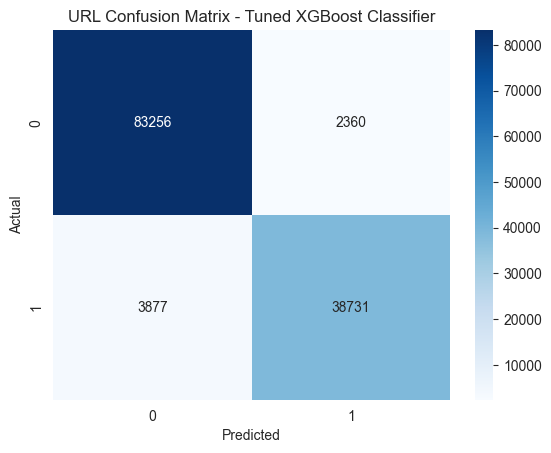

In [41]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Detailed Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title('URL Confusion Matrix - Tuned XGBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Save the Plot
plt.savefig(fname='../images/URL_Tuned_XGBoost_Confusion_Matrix.png')
plt.show()

After tuning with Optuna and enabling GPU acceleration, the XGBoost model achieved an impressive accuracy of **95.14%**, slightly outperforming the tuned Random Forest. It showed excellent balance between precision (**94%**) and recall (**91%**) for detecting malicious URLs. With fewer false negatives and solid generalization, this model demonstrates high reliability and efficiency, making it a strong candidate for deployment in real-time phishing URL detection systems.